### Bias-Variance Tradeoff

A fundamental problem with supervised learning is the bias-variance tradeoff. Ideally a model should have two key characteristics 

1) sensitive enough to accurately capture the key patterns in the training dataset, 

2) at the same time it should be generalized enough to work well on any unseen datasets. 

Unfortunately, whilst trying to achieve the afore mentioned first point, there is ample chances of over-fitting to noisy or unrepresentative training data points leading to a failure of generalizing the model. On the other hand, trying to generalize model may result in failing to capture important regularities. 


### Bias
If a model accuracy is low on training dataset as well as test dataset the model is said to be underfitting or model has high biase. This means the model is not fitting the training dataset points well in regression or decision boundary is not separating the classes well in classification, and two key reasons for bias is 1) not including the right features 2) not picking the correct order of polynomial degree for model fitting.

To solve underfitting issue or to reduced bias try including more meaningful features and try to increase the model complexity by trying higher order polynomial fittings. 

### Variance
If a model is giving high accuracy on training dataset, however on test dataset the accuracy drops drastically then the model is said to be overfitting or model has high variance. The key reason for overfitting is using higher order polynomial degree (may not be required), which will fit decision boudary tool well to all data points including the noise of train dataset, instead of the underlying relationship. This will lead to a high accuracy (actual vs predicted) in train dataset and when applied to the test dataset the prediction error will be high.

To solve over-fitting issue:
* try to reduce the number of features i.e., keep only the meanigful features or try regularization methods which will keep all the features however reduce the magnitude of the feature parameter
* Dimension reduction can eliminate noisy features, in turn reducing the model variance
* Brining more data points to make training dataset large will also reduce variance
* Choosing right model paramters can help to reduce the bias and variance, for example
    * Using right regularization parameters can decrease variance in regression based models
    * For a decision tree reducing the depth of the decision tree will reduce the variance    

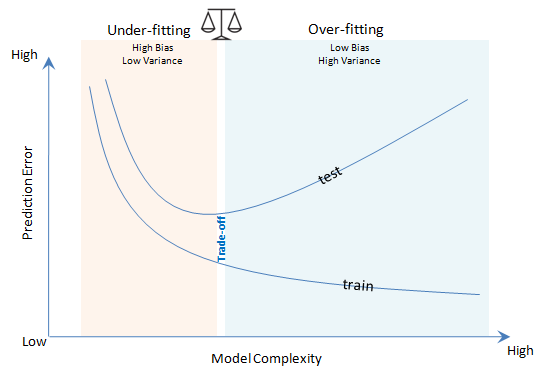

In [1]:
from IPython.display import Image
Image(filename='../Chapter 4 Figures/Bias_Variance.png', width=500)

### K-Fold Cross Validation

K-folds cross validation splits the training dataset into k folds without replacement i.e., any given data point will only be part of one of the subset, where k-1 folds are used for the model training and one fold is used for testing. The procedure is repeated k times so that we obtain k models and performance estimates.

We then calcuate the averge performance of the models based on the individual folds to obtain a performance estimate that is less sensitive to the subpartitioning of the training data compared to the holdout or single fold method.

An extended cross-validation is the Stratified K-fold cross validation, where the class proportions are preserved in each fold leading to a better bias and variance estimates.

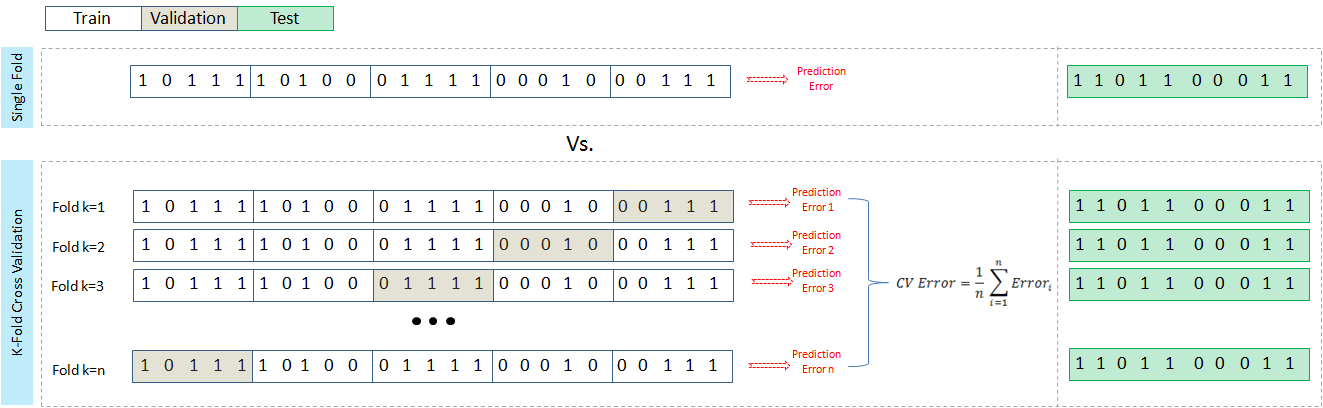

In [2]:
from IPython.display import Image
Image(filename='../Chapter 4 Figures/CV.png', width=1000)

### Hold-out or single fold model

In [3]:
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# read the data in
df = pd.read_csv("Data/Diabetes.csv")

X = df.iloc[:,:8].values     # independent variables
y = df['class'].values     # dependent variables

# Normalize Data
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

# instantiate a logistic regression model, and fit 
clf = LogisticRegression(random_state=2017)
clf = clf.fit(X_train, y_train)

# evaluate model
print ("Train Score: ", clf.score(X_train, y_train))
print ("Test Score: ", clf.score(X_test, y_test))

Train Score:  0.7728119180633147
Test Score:  0.7922077922077922


### Now let's try 5-fold cross-validation, to see if the accuracy holds up more rigorously

In [4]:
from sklearn.model_selection import cross_val_score

# evaluate the model using 10-fold cross-validation
train_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
test_scores = cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5)
print ("Train Fold AUC Scores: ", train_scores)
print ("Train CV AUC Score: ", train_scores.mean())

print ("\nTest Fold AUC Scores: ", test_scores)
print ("Test CV AUC Score: ", test_scores.mean())

Train Fold AUC Scores:  [0.80555556 0.73148148 0.81308411 0.76635514 0.71028037]
Train CV AUC Score:  0.7653513326410523

Test Fold AUC Scores:  [0.80851064 0.78723404 0.78723404 0.77777778 0.8       ]
Test CV AUC Score:  0.7921513002364066


### Let's try Stratified 5-fold cross-validation

In [5]:
kfold = model_selection.StratifiedKFold(n_splits=5, random_state=2019)

train_scores = []
test_scores = []
k = 0
for (train, test) in kfold.split(X_train, y_train):
    clf.fit(X_train[train], y_train[train])
    train_score = clf.score(X_train[train], y_train[train])
    train_scores.append(train_score)
    # score for test set
    test_score = clf.score(X_train[test], y_train[test])
    test_scores.append(test_score)
    
    k += 1
    print('Fold: %s, Class dist.: %s, Train Acc: %.3f, Test Acc: %.3f' 
          % (k, np.bincount(y_train[train]), train_score, test_score))
    
print('\nTrain CV accuracy: %.3f' % (np.mean(train_scores)))
print('Test CV accuracy: %.3f' % (np.mean(test_scores)))

Fold: 1, Class dist.: [277 152], Train Acc: 0.758, Test Acc: 0.806
Fold: 2, Class dist.: [277 152], Train Acc: 0.779, Test Acc: 0.731
Fold: 3, Class dist.: [278 152], Train Acc: 0.767, Test Acc: 0.813
Fold: 4, Class dist.: [278 152], Train Acc: 0.781, Test Acc: 0.766
Fold: 5, Class dist.: [278 152], Train Acc: 0.781, Test Acc: 0.710

Train CV accuracy: 0.773
Test CV accuracy: 0.765


Plotting a ROC curve for the stratifiedKFold

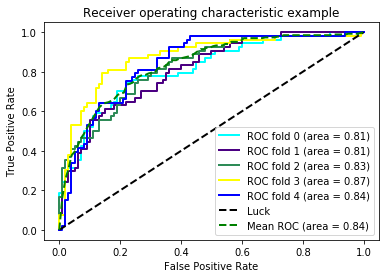

In [6]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

kfold = model_selection.StratifiedKFold(n_splits=5, random_state=2019)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, y), colors):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()